In [1]:
import time
import tarfile
import re
import urllib.request
import os
import random
import itertools
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from spacy.en import English
from HanSequenceLabellingModel import HanSequenceLabellingModel
from IPython.display import HTML, display
from sklearn.preprocessing import minmax_scale

%load_ext autoreload
%autoreload 1
%aimport HanSequenceLabellingModel
%aimport model_components
%aimport

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)

Modules to reload:
HanSequenceLabellingModel model_components

Modules to skip:



In [2]:
class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

In [3]:
class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
        self.parser = English()
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [4]:
def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [5]:
reviews = list(ImdbMovieReviews())

In [6]:
random.shuffle(reviews)

In [7]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=10)

In [8]:
def HAN_model_1(session, restore_only=False, attention=True):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
            attention=attention,
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

In [9]:
def color_text(s, attention):
    attention /= 3
    return '<text style="background-color:rgb({}, {}, 255)">{}</text>'.format(int((1 - attention) * 255), int((1 - attention) * 255), s)

def visualize(sentences, sentences_attentions, words_attentions):
    sentences_attentions = minmax_scale(sentences_attentions)
    for i in range(len(sentences)):
        sentence = sentences[i]
        colored_words = []
        attentions = minmax_scale(words_attentions[i, :len(sentence)])
        for j in range(len(sentence)):
            colored_words.append(color_text(sentence[j], attentions[j]))
        display(HTML(color_text(str(i), sentences_attentions[i]) + ' ' + ' '.join(colored_words)))
    

In [10]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)

    data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b = next(batches_split)

    fd = {
        model.is_training: True,
        model.inputs_embedded: data,
        model.word_lengths: words_per_sent_per_doc,
        model.sentence_lengths: sent_per_doc,
        model.labels: labels_batch,
        model.sample_weights: np.ones(shape=(10))
    }

    sentences_attentions_b, words_attentions_b = s.run([
            model.sentence_level_output,
            model.word_level_output,
    ], feed_dict=fd)
        
    sentences = sents_b[0]
    sentences_attentions = sentences_attentions_b[0, :len(sentences)]
    words_attentions = words_attentions_b[:len(sentences), :]
    visualize(sentences, sentences_attentions, words_attentions)

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400


Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
24

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


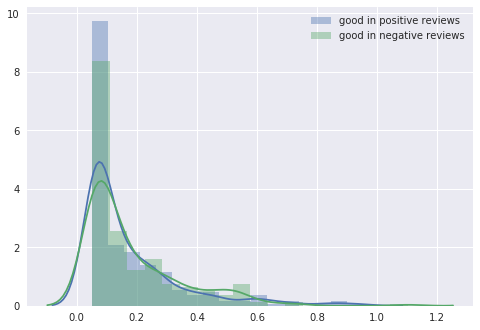

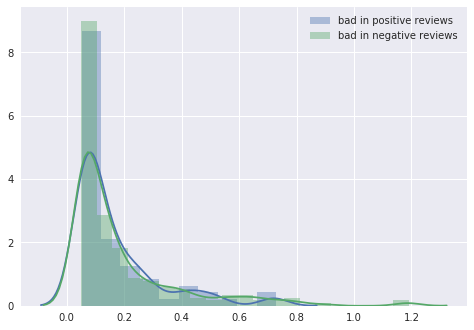

In [11]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

words = ['good', 'bad']
distribution = {}
for word in words:
    for value in [False, True]:
        distribution[(word, value)] = []
    
ITERATIONS = 500   
MIN_ATTENTION_VALUE = 0.05
    
with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b) in enumerate(batches_split):

        print(i)
        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        sentences_attentions_b, words_attentions_b = s.run([
                model.sentence_level_output,
                model.word_level_output,
        ], feed_dict=fd)
        
        sentence_number = 0
        for j in range(len(sents_b)):
            for g in range(len(sents_b[j])):
                sentence = sents_b[j][g]
                for k in range(len(sentence)):
                    if sentence[k] in words and words_attentions_b[sentence_number + g, k] >= MIN_ATTENTION_VALUE:
                        distribution[(sentence[k], labels_batch[j])].append(words_attentions_b[sentence_number + g, k])
            sentence_number += len(sents_b[j]) + 1
            
        if i == ITERATIONS:
            break
            
sns.distplot(distribution[('good', True)], label='good in positive reviews')
sns.distplot(distribution[('good', False)], label='good in negative reviews')
plt.legend()
plt.show()

sns.distplot(distribution[('bad', True)], label='bad in positive reviews')
sns.distplot(distribution[('bad', False)], label='bad in negative reviews')
plt.legend()
plt.show()

In [12]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

ITERATIONS = 1000
ACCURACY_BATCH_SIZE = 10

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    
    accuracy_sum = 0
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        accuracy = s.run([
                model.accuracy,
        ], feed_dict=fd)
        accuracy_sum += accuracy[0]
        if i % ACCURACY_BATCH_SIZE == ACCURACY_BATCH_SIZE - 1:
            print(i // ACCURACY_BATCH_SIZE, accuracy_sum / ACCURACY_BATCH_SIZE)
            accuracy_sum = 0
        
        if i == ITERATIONS:
            break
        

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
0 0.85000000596
1 0.820000004768
2 0.860000008345
3 0.820000004768
4 0.750000011921
5 0.85
6 0.780000001192
7 0.859999996424
8 0.859999990463
9 0.869999998808
10 0.830000007153
11 0.849999988079
12 0.859999996424
13 0.830000007153
14 0.84999999404
15 0.829999995232
16 0.859999996424
17 0.869999998808
18 0.840000003576
19 0.820000010729
20 0.8
21 0.780000013113
22 0.810000008345
23 0.870000004768
24 0.859999996424
25 0.859999996424
26 0.870000004768
27 0.909999990463
28 0.839999997616
29 0.889999997616
30 0.85
31 0.830000001192
32 0.860000002384
33 0.830000001192
34 0.820000004768
35 0.889999997616
36 0.870000004768
37 0.810000002384
38 0.840000003576
39 0.810000008345
40 0.85000000596
41 0.879999995232
42 0.830000013113
43 0.869999992847
44 0.870000004768
45 0.870000004768
46 0.879999989271
47 0.85000000596
48 0.830000007153
49 0.8
50 0.810000002384
51 0.86000

In [13]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

ITERATIONS = 1000
ACCURACY_BATCH_SIZE = 10

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s, attention=False)
    
    accuracy_sum = 0
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        accuracy = s.run([
                model.accuracy,
        ], feed_dict=fd)
        accuracy_sum += accuracy[0]
        if i % ACCURACY_BATCH_SIZE == ACCURACY_BATCH_SIZE - 1:
            print(i // ACCURACY_BATCH_SIZE, accuracy_sum / ACCURACY_BATCH_SIZE)
            accuracy_sum = 0
        
        if i == ITERATIONS:
            break
        

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
0 0.880000001192
1 0.790000009537
2 0.870000004768
3 0.859999996424
4 0.760000014305
5 0.800000017881
6 0.85
7 0.829999998212
8 0.780000001192
9 0.680000025034
10 0.770000010729
11 0.830000007153
12 0.790000009537
13 0.84999999404
14 0.790000015497
15 0.80000000596
16 0.770000010729
17 0.730000013113
18 0.790000009537
19 0.750000023842
20 0.820000004768
21 0.780000013113
22 0.769999998808
23 0.760000008345
24 0.880000001192
25 0.89999999404
26 0.790000015497
27 0.85
28 0.760000008345
29 0.85
30 0.67000002563
31 0.789999997616
32 0.810000008345
33 0.780000007153
34 0.790000021458
35 0.820000004768
36 0.730000016093
37 0.770000004768
38 0.819999998808
39 0.780000013113
40 0.830000007153
41 0.780000007153
42 0.859999996424
43 0.810000008345
44 0.830000001192
45 0.670000013709
46 0.80000000596
47 0.829999995232
48 0.760000008345
49 0.75000000596
50 0.820000004768


ValueError: not enough values to unpack (expected 2, got 0)

We got accuracy worse than model with attention weights.